## Taxi Trip Fare Prediction Challenge

Through a real-world challenge, this hackathon aims to enhance competitors' data science and innovative analytical thinking abilities. Get an opportunity to work on a remarkable data science technology by competing with the best brains in this area at this point in time, where artificial intelligence and machine learning are at the forefront of attention, and find out how you stack up!

This hackathon will try to address the challenges faced by taxi operators in quoting the right fare to customers before starting the trip. However, the details are shared with taxi drivers or operators related to the trip, they find it difficult to quote the right fare because of uncertainties and calculation complexities. The same issue is faced by passengers as well because of inaccurate or irrelevant fares quoted. To find a solution for this, this hackathon provides a historical dataset to participants that includes records of taxi trip details and fares of those trips. Using this dataset, the participants need to build machine learning models for predicting the trip fare based on the given other useful features of the trip.

Overall, it involves using a dataset, finding the best set of features from the dataset, building a machine learning model to predict trip fare based on other trip features and evaluating the predictions using mean squared error and finally submitting the predictions in the given template.

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.formula.api as sfa
import statsmodels.api as sma

# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
# Terminal --> pip install mlxtend

#from mlxtend.feature_selection

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,9.01,1,N,1,26.0,0.0,0.5,8.14,5.76,0.3,40.70,262,138,2018,3,7,2,6,2131.0,24.30
1,0.20,1,N,1,3.0,0.0,0.5,0.75,0.00,0.3,4.55,263,236,2018,2,25,6,10,2377.0,37.40
2,9.65,1,N,1,41.5,0.0,0.5,9.61,5.76,0.3,57.67,138,230,2018,1,29,0,8,1286.0,30.36
3,9.50,1,N,1,30.0,0.5,0.5,9.25,5.76,0.3,46.31,186,138,2018,9,25,1,20,2586.0,4.30
4,5.80,1,N,1,21.5,0.5,0.5,4.56,0.00,0.3,27.36,162,87,2018,8,20,0,21,1575.0,23.80


In [3]:
# combine the dataset
combined = pd.concat([train,test], ignore_index=False)

### Univariate analysis

In [4]:
num_cols = combined.select_dtypes(include = np.number).columns
cat_cols = combined.select_dtypes(include = np.number).columns

In [5]:
num_cols = ['trip_distance', 'fare_amount', 'extra',
       'tip_amount', 'tolls_amount', 'imp_surcharge',
       'total_amount','trip_duration']

cat_cols = ['payment_type','month', 'day', 'day_of_week', 'hour_of_day','store_and_fwd_flag',
            'rate_code', 'mta_tax']
            

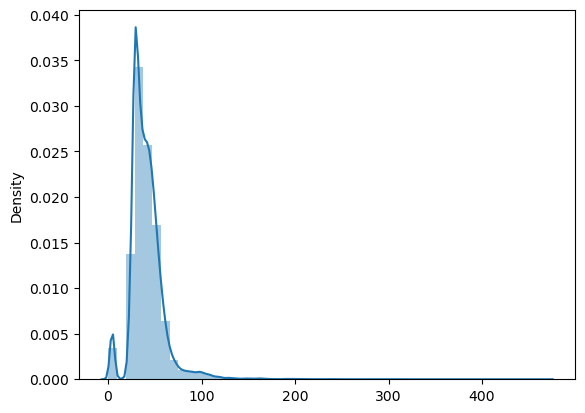

In [6]:
sns.distplot(x = combined['calculated_total_amount'])
plt.show()

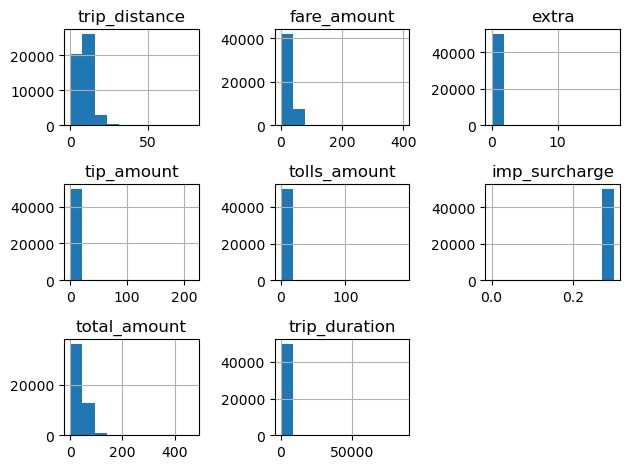

In [7]:
# Numerical vars 
combined.loc[:, num_cols].hist()
plt.tight_layout()
plt.show()

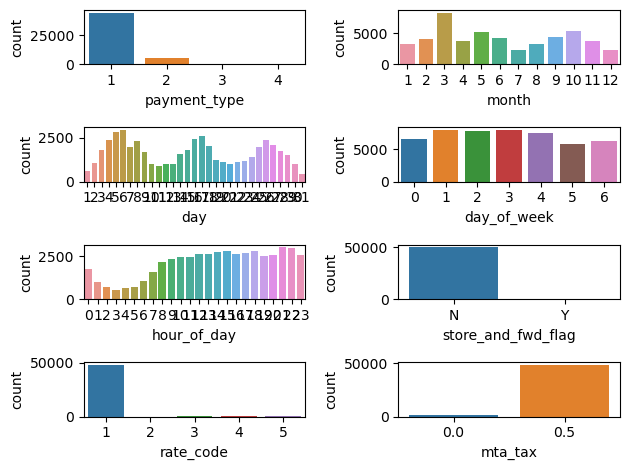

In [8]:
# Categorical vars
t = 1
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(x = i, data = combined)
    t += 1
plt.tight_layout()
plt.show()

### Missing values


In [9]:
combined.isnull().sum()

trip_distance                  0
rate_code                      0
store_and_fwd_flag             0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
imp_surcharge                  0
total_amount                   0
pickup_location_id             0
dropoff_location_id            0
year                           0
month                          0
day                            0
day_of_week                    0
hour_of_day                    0
trip_duration                  0
calculated_total_amount    15000
dtype: int64

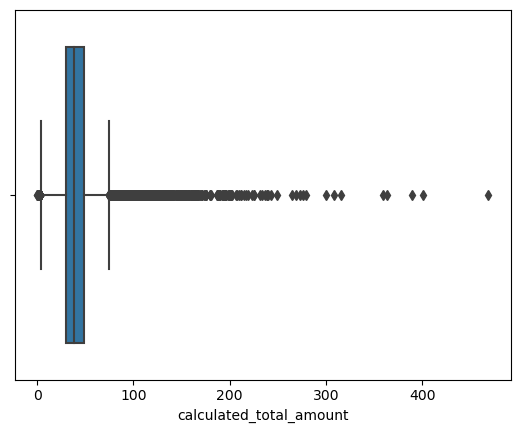

In [10]:
# checking outlier in taregt variable
sns.boxplot(x = combined['calculated_total_amount'])
plt.show()

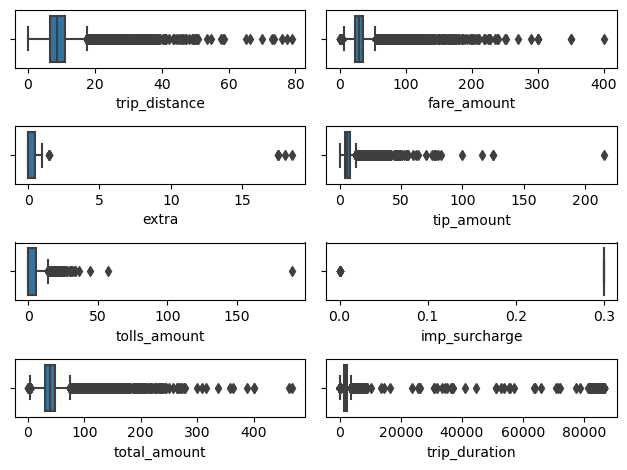

In [11]:
t = 1
for i in num_cols:
    plt.subplot(4,2,t)
    sns.boxplot(x = combined[i])
    t += 1
plt.tight_layout()
plt.show()

### Feature engineering

In [12]:
# Amount per distance
combined['amount_per_mile'] = combined['total_amount']/combined['trip_distance']


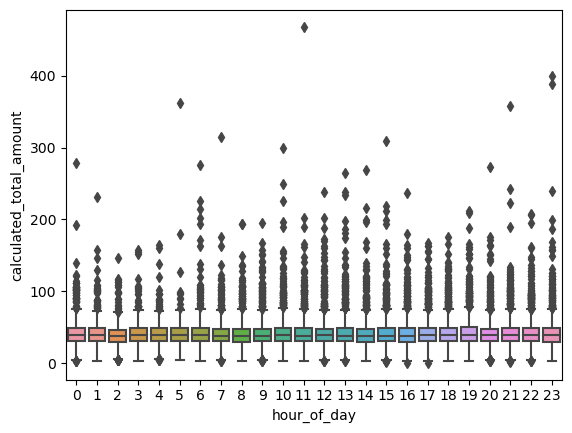

In [13]:
# hour of the day and y variable box plot

sns.boxplot(data = combined, x = 'hour_of_day', y = 'calculated_total_amount')
plt.show()

# 5, 6, 10, 11, 13, 14, 15, 20, 21, 23

In [14]:
# 5, 6, 10, 11, 13, 14, 15, 20, 21, 23
# Binning
combined['peak_hours'] = combined.hour_of_day.apply(lambda x:1 if x in [5, 6, 10, 11, 13, 14, 15,
                                               20, 21, 23] else 0)

<Axes: xlabel='peak_hours', ylabel='calculated_total_amount'>

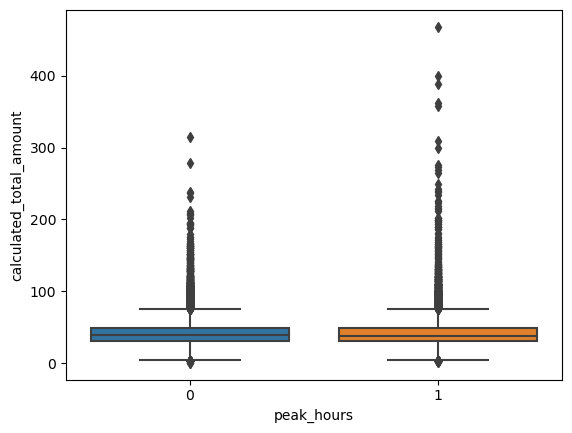

In [15]:
sns.boxplot(data = combined, x = 'peak_hours', y = 'calculated_total_amount')
# Peak hours has a relation with our target var because we engineered it on the basis of our
# Traget variable

In [16]:
combined['day_wise_mean_of_fareamount']= combined.groupby(by = ['day'])\
['fare_amount'].transform('mean')

In [17]:
combined.drop(columns = ['day_wise_mean_of_fareamount'],inplace = True)

In [18]:
combined['day_wise_mean_of_totalamount']= combined.groupby(by = ['day'])['total_amount'].transform('mean')
combined['day_wise_median_of_totalamount']= combined.groupby(by = ['day'])['total_amount'].transform('median')
combined['day_wise_min_of_totalamount']= combined.groupby(by = ['day'])['total_amount'].transform('min')
combined['day_wise_max_of_totalamount']= combined.groupby(by = ['day'])['total_amount'].transform('max')



In [19]:
combined['month_mean_of_totalamount']= combined.groupby(by = ['month'])['total_amount'].transform('mean')
combined['month_median_of_totalamount']= combined.groupby(by = ['month'])['total_amount'].transform('median')
combined['month_min_of_totalamount']= combined.groupby(by = ['month'])['total_amount'].transform('min')
combined['month_max_of_totalamount']= combined.groupby(by = ['month'])['total_amount'].transform('max')

In [20]:
combined['trip_count'] = combined.groupby(by = ['pickup_location_id'])['dropoff_location_id'].transform('nunique')

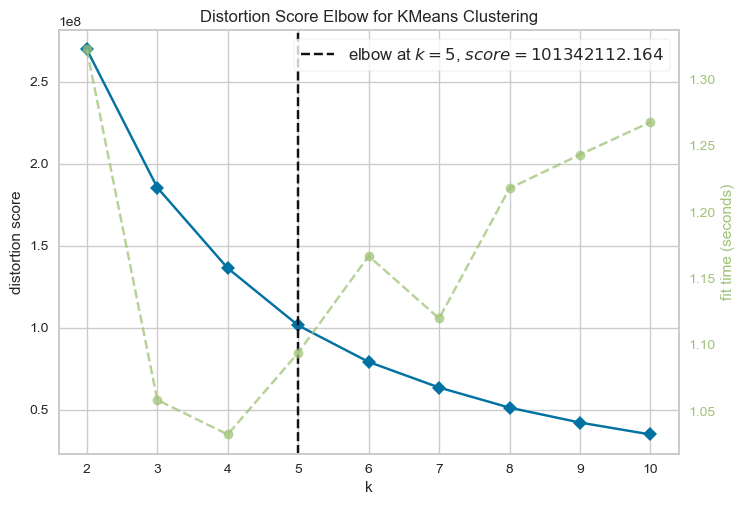

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# usning pickup locations id and drop id we can we can create geo locations id
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
kmeans = KMeans()
visualizer = KElbowVisualizer(estimator=kmeans)

visualizer.fit(combined.loc[:, ['pickup_location_id','dropoff_location_id']])

visualizer.show()

In [22]:
# Deploy the KMeans clustering and generate the clusters

kmeans = KMeans(n_clusters=5, random_state = 42)

kmeans.fit(combined.loc[:, ['pickup_location_id','dropoff_location_id']])
kmeans.cluster_centers_ # centroid 
combined['geo_location'] = kmeans.labels_

In [23]:
# Trip count basis rate code

combined['trip_count_rate_code'] = combined.groupby\
(['rate_code'])['total_amount'].transform('nunique')

combined['trip_mean_rate_code'] = combined.groupby\
(['rate_code'])['total_amount'].transform('mean')

combined['trip_median_rate_code'] = combined.groupby\
(['rate_code'])['total_amount'].transform('median')

combined['trip_min_rate_code'] = combined.groupby\
(['rate_code'])['total_amount'].transform('min')

combined['trip_max_rate_code'] = combined.groupby\
(['rate_code'])['total_amount'].transform('max')

In [24]:
# trip count basis payment type

combined['trip_count_pmt_type'] = combined.groupby\
(['payment_type'])['total_amount'].transform('nunique')

combined['trip_mean_pmt_type'] = combined.groupby\
(['payment_type'])['total_amount'].transform('mean')

combined['trip_median_pmt_type'] = combined.groupby\
(['payment_type'])['total_amount'].transform('median')

combined['trip_min_pmt_type'] = combined.groupby\
(['payment_type'])['total_amount'].transform('min')

combined['trip_max_pmt_type'] = combined.groupby\
(['payment_type'])['total_amount'].transform('max')

In [25]:
hours = combined['trip_duration']/3600
combined['milers_per_hour'] = combined.trip_distance/hours

In [26]:
# split the data in train and test
newtrain = combined.iloc[0:train.shape[0], :]
newtest = combined.iloc[train.shape[0]:, :]

newtrain.shape, newtest.shape, train.shape, test.shape

((35000, 43), (15000, 43), (35000, 20), (15000, 19))

In [27]:
newtest.drop(columns = ['calculated_total_amount'],inplace = True)

In [28]:
nums = ['trip_distance','fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge',
       'total_amount','trip_duration','amount_per_mile',
       'day_wise_mean_of_totalamount', 'day_wise_median_of_totalamount',
       'day_wise_min_of_totalamount', 'day_wise_max_of_totalamount',
       'month_mean_of_totalamount', 'month_median_of_totalamount',
       'month_min_of_totalamount', 'month_max_of_totalamount', 'trip_count',
       'trip_count_rate_code', 'trip_mean_rate_code', 'trip_median_rate_code',
       'trip_min_rate_code', 'trip_max_rate_code', 'trip_count_pmt_type',
       'trip_mean_pmt_type', 'trip_median_pmt_type', 'trip_min_pmt_type',
       'trip_max_pmt_type', 'milers_per_hour']

In [29]:
imp_feat = []
for i in nums:
    teststats, pvalue = stats.ttest_ind(newtrain.loc[:,i], newtrain.calculated_total_amount)
    
    if pvalue < 0.05:
        #print(i)
        imp_feat.append(i)
    else:
        pass

In [30]:
x = newtrain.loc[:,imp_feat]

In [31]:
x.columns

Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'imp_surcharge', 'trip_duration', 'amount_per_mile',
       'day_wise_median_of_totalamount', 'day_wise_min_of_totalamount',
       'day_wise_max_of_totalamount', 'month_median_of_totalamount',
       'month_min_of_totalamount', 'month_max_of_totalamount', 'trip_count',
       'trip_count_rate_code', 'trip_median_rate_code', 'trip_min_rate_code',
       'trip_max_rate_code', 'trip_count_pmt_type', 'trip_median_pmt_type',
       'trip_min_pmt_type', 'trip_max_pmt_type', 'milers_per_hour'],
      dtype='object')

In [32]:
cats = ['rate_code','store_and_fwd_flag','payment_type','peak_hours','geo_location']

In [33]:
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm

model = sfa.ols('calculated_total_amount~rate_code+store_and_fwd_flag+payment_type+peak_hours+\
geo_location',data = newtrain).fit()

anova_lm(model)

# only rate code and payment type are statistically important


,df,sum_sq,mean_sq,F,PR(>F)
store_and_fwd_flag,1.0,3.789820e+02,378.982032,1.033316,3.093882e-01
rate_code,1.0,1.768833e+03,1768.832509,4.822821,2.809188e-02
payment_type,1.0,2.104208e+04,21042.075231,57.372398,3.695046e-14
peak_hours,1.0,1.406474e+00,1.406474,0.003835,9.506221e-01
geo_location,1.0,7.909400e+01,79.094005,0.215654,6.423742e-01
Residual,34994.0,1.283451e+07,366.763042,NaN,NaN


In [34]:
x['rate_code'] = newtrain['rate_code']
x['payment_type'] = newtrain['payment_type']

In [35]:
finaltest = newtest.loc[:,x.columns]

In [36]:
num_cols = x.iloc[:,:-2].columns

In [37]:
# robust scaler to remove the outliers effect
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
# train = x
scaled_x = pd.DataFrame(robust.fit_transform(x.loc[:, num_cols]),columns = num_cols)

# test = finaltest
scaled_test = pd.DataFrame(robust.transform(finaltest.loc[:, num_cols]), columns = num_cols)

In [38]:
scaled_x['rate_code'] = x['rate_code']
scaled_x['payment_type'] = x['payment_type']

scaled_test['rate_code'] = x['rate_code']
scaled_test['payment_type'] = x['payment_type']

In [39]:
# modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [40]:
# Base models

def base_models():
    models = dict()
    models['LR'] = LinearRegression()
    models['DT'] = DecisionTreeRegressor()
    models['RF'] = RandomForestRegressor()
    models['GBM'] =GradientBoostingRegressor()
    models['XGBM'] = XGBRegressor()
    return models
    

In [41]:
# function to eavaluate the models
from sklearn.model_selection import KFold
my_v = newtrain.calculated_total_amount

def eval_models(model):
    cv = KFold(n_splits = 5, shuffle=True, random_state=1002)
    scores = -cross_val_score(estimator=model, X = scaled_x, y = my_v, cv = cv,
                             scoring = 'neg_mean_squared_error', n_jobs=-1)
    return scores 
    
    

In [42]:
# Lets use the functions to calculate the scores

models = base_models()

result, names = list(), list()

for name, mymodel in models.items():
    finalscore = eval_models(mymodel)
    result.append(finalscore)
    names.append(name)
    print(name, np.mean(result))

LR 367.1946437513258
DT 607.3293621128058
RF 532.6295764389941
GBM 491.58740359263527
XGBM 472.8213758138232


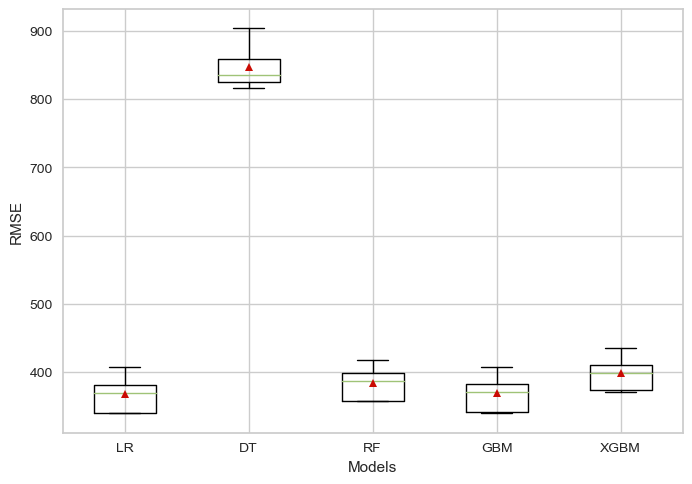

In [47]:
# Plot the results

plt.boxplot(result, labels = names, showmeans = True)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()


In [51]:
# Stacking

from sklearn.ensemble import StackingRegressor

GBM = GradientBoostingRegressor()
XGB = XGBRegressor()
LR = LinearRegression()
stack = StackingRegressor(estimators=[('GBM',GBM),
                                      ('XGB', XGB)],
                          final_estimator=LinearRegression(),cv = 5)

predictions = stack.fit(scaled_x, my_v).predict(scaled_test)

In [52]:
predictions

array([40.69804541, 41.60012851, 41.48464145, ..., 41.95364736,
       41.02942888, 41.38718215])

In [54]:
submission = pd.read_csv('submission.csv')
submission.head()

,calculated_total_amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [55]:
submission['calculated_total_amount'] = predictions

In [56]:
submission.to_csv('prelunch_model.csv',index = False)

In [57]:
cd

C:\Users\sidharth nandal
